In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# # Navigate to your project folder
# %cd '/content/drive/My Drive/Colab Notebooks/TPC-LoS-prediction-master'

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import time

In [ ]:
def load_core_data():
    """Load required tables with error handling"""
    raw_path = r"...\TPC-LoS-prediction-master\data\mimic_subset" # Modify the ... to correct path

    try:
        return {
            'patients': pd.read_csv(os.path.join(raw_path, 'patients.csv.gz')),
            'admissions': pd.read_csv(os.path.join(raw_path, 'admissions.csv.gz')),
            'icustays': pd.read_csv(os.path.join(raw_path, 'icustays.csv.gz'))
        }
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Ensure files exist at:")
        print(f"- {os.path.join(raw_path, 'patients.csv.gz')}")
        print(f"- {os.path.join(raw_path, 'admissions.csv.gz')}")
        print(f"- {os.path.join(raw_path, 'icustays.csv.gz')}")
        raise

dfs = load_core_data()

In [5]:
# Merge
merged = pd.merge(
    dfs['patients'][['subject_id', 'anchor_age', 'gender', 'dod']],
    dfs['admissions'][['subject_id', 'hadm_id', 'admittime', 'dischtime', 'hospital_expire_flag']],
    on='subject_id'
)

merged = pd.merge(
    merged,
    dfs['icustays'][['hadm_id', 'intime', 'outtime', 'los', 'first_careunit']],
    on='hadm_id'
)

In [6]:
# Convert datetimes
merged['intime'] = pd.to_datetime(merged['intime'])
merged['outtime'] = pd.to_datetime(merged['outtime'])
merged['admittime'] = pd.to_datetime(merged['admittime'])

# Calculate LOS in hours
merged['los_hours'] = (merged['outtime'] - merged['intime']).dt.total_seconds() / 3600

# Filter outliers
merged = merged[(merged['los_hours'] > 4) & (merged['los_hours'] <= 720)]

# Create features
merged['is_male'] = (merged['gender'] == 'M').astype(int)
merged['first_careunit'] = merged['first_careunit'].astype('category').cat.codes
merged['mortality'] = merged['hospital_expire_flag'].fillna(0).astype(int)

# Add time based features
merged['admit_dayofweek'] = merged['admittime'].dt.dayofweek
merged['admit_hour'] = merged['admittime'].dt.hour
merged['admit_month'] = merged['admittime'].dt.month

# Add pre ICU LOS
merged['pre_icu_los_hours'] = (merged['intime'] - merged['admittime']).dt.total_seconds() / 3600

# Create interaction features
merged['age_x_icu'] = merged['anchor_age'] * merged['first_careunit']
merged['age_x_pre_icu'] = merged['anchor_age'] * merged['pre_icu_los_hours']

In [7]:
# Prepare Model Data and Split
features = merged[['anchor_age', 'is_male', 'first_careunit', 'pre_icu_los_hours',
                   'admit_dayofweek', 'admit_hour', 'admit_month',
                   'age_x_icu', 'age_x_pre_icu']]

target = merged['los_hours'].values

X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.2,
    random_state=42
)

In [8]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# Train Model (Random Forest with Hyperparameter Tuning)
param_grid = {
    'n_estimators': [100],
    'max_depth': [6, 8],
    'min_samples_split': [4, 8],
    'min_samples_leaf': [2, 4]
}

# Manual GridSearchCV with tqdm for progress
def manual_grid_search(X, y, param_grid, cv=3, scoring='neg_mean_absolute_error'):
    best_score = float('-inf')
    best_params = None
    all_results = []

    # All possible combs of params
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    for params in tqdm(param_combinations, desc="Grid Search"):
        start_time = time.time()
        scores = []
        for i in range(cv):
            X_train_cv, X_val_cv, y_train_cv, y_val_cv = train_test_split(X, y, test_size=1/cv, random_state=i*42)
            model = RandomForestRegressor(random_state=42, n_jobs=-1, **params)
            model.fit(X_train_cv, y_train_cv)
            preds = model.predict(X_val_cv)
            score = mean_absolute_error(y_val_cv, preds)
            scores.append(score)

        mean_score = np.mean(scores)
        total_time = time.time() - start_time
        result = {'params': params, 'mean_mae': mean_score, 'time':total_time}
        all_results.append(result)

        if -mean_score > best_score:
            best_score = -mean_score
            best_params = params

    return best_params, best_score, all_results

import itertools
best_params, best_score, all_results = manual_grid_search(X_train, y_train, param_grid)

print(f"Best parameters: {best_params}")
print(f"Best Score (Negative MAE): {best_score}")

# Train final model
best_model = RandomForestRegressor(random_state=42, n_jobs=-1, **best_params)
best_model.fit(X_train, y_train)

Grid Search:   0%|          | 0/8 [00:00<?, ?it/s]

Best parameters: {'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 4}
Best Score (Negative MAE): -59.617373152903646


RandomForestRegressor(max_depth=8, min_samples_leaf=4, min_samples_split=4,
                      n_jobs=-1, random_state=42)

In [10]:
# Predictions and Evaluate
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f} hours")

Mean Absolute Error: 60.38 hours


In [11]:
import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Architecture
class LOSPredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        return self.fc4(x)

# Data Loaders
def create_torch_loaders(X_train, X_test, y_train, y_test, batch_size=64):
    train_dataset = TensorDataset(
        torch.FloatTensor(X_train),
        torch.FloatTensor(y_train)
    )
    test_dataset = TensorDataset(
        torch.FloatTensor(X_test),
        torch.FloatTensor(y_test)
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, test_loader

# Initialize Model with Correct Dimensions
input_size = X_train.shape[1]
train_loader, test_loader = create_torch_loaders(X_train, X_test, y_train, y_test)

model = LOSPredictor(input_size).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.HuberLoss()

# Enhanced Training Loop
num_epochs = 20
best_mae = float('inf')
patience = 5
no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        running_loss += loss.item()

    # Validation
    model.eval()
    val_preds = []
    val_targets = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()
            val_preds.extend(outputs.cpu().numpy())
            val_targets.extend(targets.cpu().numpy())

    val_mae = mean_absolute_error(val_targets, val_preds)
    avg_loss = running_loss / len(train_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {avg_loss:.4f} | Val MAE: {val_mae:.2f} hours')

    # Early stopping
    if val_mae < best_mae:
        best_mae = val_mae
        no_improve = 0
        torch.save(model.state_dict(), 'best_los_model.pth')
    else:
        no_improve += 1

    if no_improve >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

# Load Best Model
model.load_state_dict(torch.load('best_los_model.pth'))

Epoch [1/20]
Train Loss: 54.5721 | Val MAE: 54.33 hours
Epoch [2/20]
Train Loss: 53.2119 | Val MAE: 54.08 hours
Epoch [3/20]
Train Loss: 53.1074 | Val MAE: 54.07 hours
Epoch [4/20]
Train Loss: 53.0636 | Val MAE: 53.97 hours
Epoch [5/20]
Train Loss: 52.9356 | Val MAE: 54.00 hours
Epoch [6/20]
Train Loss: 52.9117 | Val MAE: 54.11 hours
Epoch [7/20]
Train Loss: 52.9683 | Val MAE: 53.99 hours
Epoch [8/20]
Train Loss: 52.8948 | Val MAE: 53.89 hours
Epoch [9/20]
Train Loss: 52.8680 | Val MAE: 53.89 hours
Epoch [10/20]
Train Loss: 52.8449 | Val MAE: 53.95 hours
Epoch [11/20]
Train Loss: 52.8023 | Val MAE: 53.85 hours
Epoch [12/20]
Train Loss: 52.8024 | Val MAE: 53.84 hours
Epoch [13/20]
Train Loss: 52.7440 | Val MAE: 53.84 hours
Epoch [14/20]
Train Loss: 52.7284 | Val MAE: 53.93 hours
Epoch [15/20]
Train Loss: 52.7204 | Val MAE: 53.87 hours
Epoch [16/20]
Train Loss: 52.6582 | Val MAE: 53.81 hours
Epoch [17/20]
Train Loss: 52.7188 | Val MAE: 53.89 hours
Epoch [18/20]
Train Loss: 52.6689 | Val 

<All keys matched successfully>

In [12]:
# Evaluate Model
model.eval()
with torch.no_grad():
    all_preds = []
    all_targets = []

    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs).squeeze()

        all_preds.extend(outputs.cpu().numpy().flatten())
        all_targets.extend(targets.cpu().numpy().flatten())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    mae = np.mean(np.abs(all_targets - all_preds))
    rmse = np.sqrt(np.mean((all_targets - all_preds)**2))
    r2 = 1 - (np.sum((all_targets - all_preds)**2) /
              np.sum((all_targets - np.mean(all_targets))**2))

    print(f'Mean Absolute Error: {mae:.2f} hours')
    print(f'Root Mean Squared Error: {rmse:.2f} hours')
    print(f'R² Score: {r2:.2f}')

Mean Absolute Error: 53.80 hours
Root Mean Squared Error: 103.27 hours
R² Score: -0.11


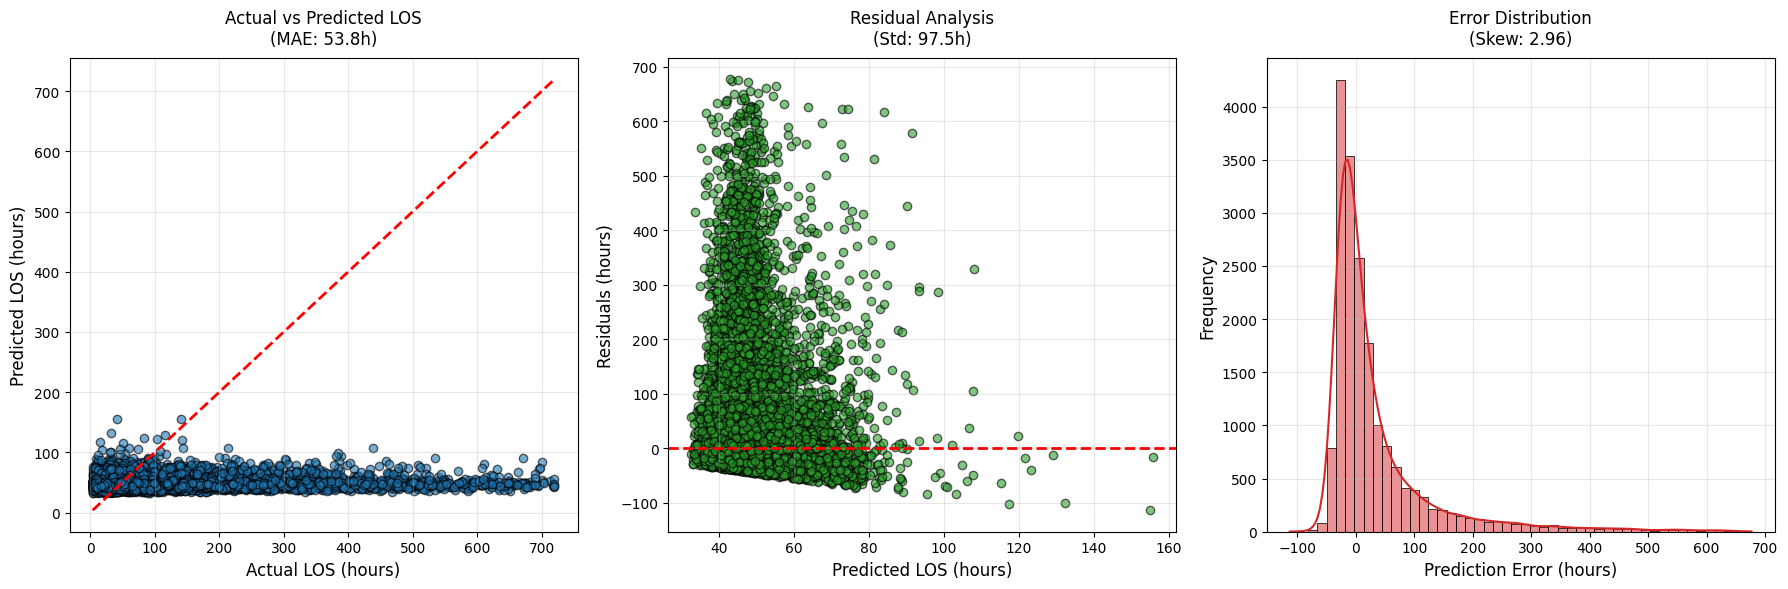

In [13]:
# Visualization
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(all_targets, all_preds, alpha=0.6, c='#1f77b4', edgecolor='k')
plt.plot([min(all_targets), max(all_targets)],
         [min(all_targets), max(all_targets)],
         'r--', lw=2)
plt.xlabel('Actual LOS (hours)', fontsize=12)
plt.ylabel('Predicted LOS (hours)', fontsize=12)
plt.title('Actual vs Predicted LOS\n(MAE: {:.1f}h)'.format(mae), pad=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
residuals = all_targets - all_preds
plt.scatter(all_preds, residuals, alpha=0.6, c='#2ca02c', edgecolor='k')
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted LOS (hours)', fontsize=12)
plt.ylabel('Residuals (hours)', fontsize=12)
plt.title('Residual Analysis\n(Std: {:.1f}h)'.format(np.std(residuals)), pad=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
sns.histplot(residuals, bins=50, kde=True, color='#d62728')
plt.xlabel('Prediction Error (hours)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Error Distribution\n(Skew: {:.2f})'.format(pd.Series(residuals).skew()), pad=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()